In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def label_category(tail, shape):
    if tail == "T" and shape == "S":
        return "high"
    elif tail == "N" and shape == "C":
        return "low"
    else:
        return "medium"

def extract_basic_info(csv_path):
    df = pd.read_csv(csv_path)
    
    # Responses about food needed
    train_responses = df['slider_train.response'].dropna().tolist()

    #Actual food needed
    food_amount = df['food_amount'].dropna().tolist()
    
    # Feedback
    feedback = df['feedback_text.text'].dropna().tolist()
    
    # Trial stop time
    #Turn ISI values into list
    isi_values = df['ISI.stopped'].dropna().tolist()
    #Get the ISI value for the last training trial, store it
    trial_stop_time = isi_values[-1] if isi_values else np.nan

    #First row with a non-empty value in 'images_list', which shows the order of testing images presented
    images_row = df[df['images_list'].notna()].iloc[0] if not df[df['images_list'].notna()].empty else None
    #Turn the images from PNGs to names
    images = [img.split('/')[-1].replace('.png','') for img in images_row['images_list'].split(',')]


    #Add in the order of images during training
    training_image_order = 
    training_image_order_cleaned = [img.split('/')[-1].replace('.png','') for img in images_row['images_file'].split(',')]

    #First row with a non-empty value in 'sliderRatings', which shows the ratings for testing images
    ratings_row = df[df['sliderRatings'].notna()].iloc[0] if not df[df['sliderRatings'].notna()].empty else None
    #Turn them into floats split by commas
    ratings = [float(r) for r in ratings_row['sliderRatings'].strip('[]').split(',')]


    categories =  [label_category(stim.split('_')[0], stim.split('_')[2]) for stim in images]
    condition = images_row['condition'] if images_row is not None and 'condition' in images_row else np.nan
        
    # Slider responses
    columns_to_extract = [
        'shape_discrete_slider.response',
        'color_discrete_slider.response',
        'tail_discrete_slider.response',
        'shape_direction_slider.response',
        'color_direction_slider.response',
        'tail_direction_slider.response',
        'shape_continuous_slider.response',
        'color_continuous_slider.response',
        'tail_continuous_slider.response'
    ]

    slider_responses = {}
    for col in columns_to_extract:
        nonempty_rows = df[df[col].notna()]
        if not nonempty_rows.empty:
            # Take the first non-empty response
            val = nonempty_rows.iloc[0][col]
        else:
            val = np.nan
        slider_responses[col] = val

    result = {
        'participant': os.path.basename(csv_path)[:3],
        'train_responses': train_responses,
        'food_amount': food_amount,
        'error': [abs(pred - actual) for pred, actual in zip(train_responses, food_amount)],
        'feedback': feedback,
        'trial_stop_time': trial_stop_time,
        'image_order': images,
        'ratings': ratings,
        'categories': categories,
        'conditionOrder': condition
    }
    result.update(slider_responses)
    return result

topdir = '/Users/sm6511/Desktop/Prediction-Accomodation-Exp'
datadir = os.path.join(topdir, 'data/Predict')
cleaneddir = os.path.join(topdir, 'data/Cleaned')
all_participants = []

for fname in os.listdir(datadir):
    if fname.endswith('.csv') and fname:
        participant_id = fname[:3]
        if '2025-11-21' not in fname:  # skip files
            continue
        csv_path = os.path.join(datadir, fname)
        print(csv_path)
        info = extract_basic_info(csv_path)
        all_participants.append(info)


df_all = pd.DataFrame(all_participants)
df_all.to_csv(os.path.join(cleaneddir, 'PrePilotPredict.csv'), index=False)
print(df_all)

/Users/sm6511/Desktop/Prediction-Accomodation-Exp/data/Predict/004_test_2025-11-21_15h25.18.750.csv
consent_survey.block_1/consentChoice                          NaN
condition                                                       4
date                                      2025-11-21_15h25.18.750
expName                                                      test
psychopyVersion                                          2025.1.1
                                                   ...           
feedback_text.text                                            NaN
button_end.numClicks                                          NaN
button_end.timesOn                                            NaN
button_end.timesOff                                           NaN
survey_debrief.block_1/debriefComplete                        NaN
Name: 6, Length: 130, dtype: object
/Users/sm6511/Desktop/Prediction-Accomodation-Exp/data/Predict/001_test_2025-11-21_15h04.41.778.csv
consent_survey.block_1/consentChoice  

In [12]:
participant_id = '006'

row = df_all[df_all['participant'] == participant_id]

free_texts = row['train_responses'].iloc[0] 
feedback = row['feedback'].iloc[0]
print(f"Train responses {participant_id}:")
for i, text in enumerate(free_texts, 1):
    print(f"Response {i}: {text}")

print(f"\nFeedback for participant {participant_id}: {feedback}")

Train responses 006:
Response 1: 2.0
Response 2: 2.0
Response 3: 2.0
Response 4: 10.0
Response 5: 10.0
Response 6: 7.0
Response 7: 7.0
Response 8: 3.0
Response 9: 9.0
Response 10: 6.0
Response 11: 4.0
Response 12: 2.0
Response 13: 6.0
Response 14: 5.0
Response 15: 3.0
Response 16: 1.0
Response 17: 5.0
Response 18: 5.0
Response 19: 7.0
Response 20: 4.0
Response 21: 6.0
Response 22: 1.0
Response 23: 1.0
Response 24: 5.0

Feedback for participant 006: []


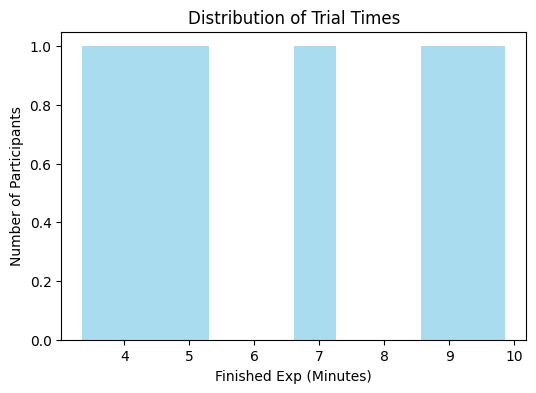

In [14]:
plt.figure(figsize=(6,4))
plt.hist(df_all['trial_stop_time'].dropna()/60, bins=10, color='skyblue', alpha=0.7)
plt.xlabel('Finished Exp (Minutes)')
plt.ylabel('Number of Participants')
plt.title('Distribution of Trial Times')
plt.savefig('PrePilotPlots/trial_times_histogramPredict.png')
plt.show()

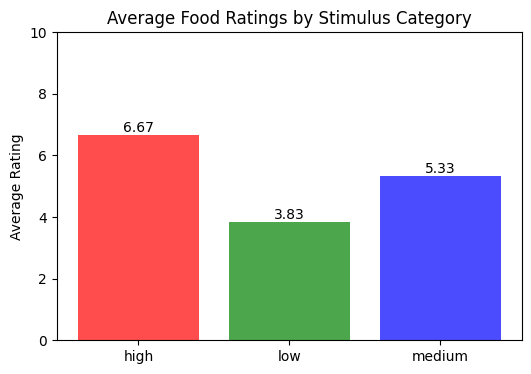

In [16]:
def AverageFoodCalclator(participants_to_use):
    df_subset = df_all[df_all['participant'].isin(participants_to_use)]
    all_trials = []
    for i in df_subset['participant']:
        trial_order = df_subset[df_subset['participant'] == i]['image_order'].iloc[0]
        ratings = df_subset[df_subset['participant'] == i]['ratings'].iloc[0]
        categories = df_subset[df_subset['participant'] == i]['categories'].iloc[0]
    
        df_participant = pd.DataFrame({
            'participant': i,
            'trial_order': trial_order,
            'ratings': ratings,
            'categories': categories
        })
        all_trials.append(df_participant)
    df_average = pd.concat(all_trials, ignore_index=True)
    avg_ratings = df_average.groupby('categories')['ratings'].mean()
    return avg_ratings

participants_to_use = df_all['participant'].tolist()
#participants_to_use = ['002', '003', '004']
avg_ratings = AverageFoodCalclator(participants_to_use)

plt.figure(figsize=(6,4))
bars = plt.bar(avg_ratings.index, avg_ratings.values, color=['red','green','blue'], alpha=0.7)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f"{bar.get_height():.2f}", ha='center')
plt.ylabel('Average Rating')
plt.title('Average Food Ratings by Stimulus Category')
plt.ylim(0, 10)
plt.savefig('PrePilotPlots/FoodRatingsPredict.png')
plt.show()


In [17]:
'shape_discrete_slider.response',
'color_discrete_slider.response',
'tail_discrete_slider.response',
'shape_direction_slider.response',
'color_direction_slider.response',
'tail_direction_slider.response',
'shape_continuous_slider.response',
'color_continuous_slider.response',
'tail_continuous_slider.response'

shape_relevance = 0
tail_relevance = 0
color_relevance = 0
for i in df_all['participant']:
    tail_int = df_all[df_all['participant'] == i]['tail_discrete_slider.response'].iloc[0]
    shape_int = df_all[df_all['participant'] == i]['shape_discrete_slider.response'].iloc[0]
    color_int = df_all[df_all['participant'] == i]['color_discrete_slider.response'].iloc[0]
    tail_relevance += 1 if tail_int == 'Yes' else 0
    shape_relevance += 1 if shape_int == 'Yes' else 0
    color_relevance += 1 if color_int== 'Yes' else 0
print("Tail Relevance:",  tail_relevance)
print("Shape Relevance", shape_relevance)
print("Color Relevance", color_relevance)





Tail Relevance: 5
Shape Relevance 6
Color Relevance 3


In [18]:
columns_direction = [
    'shape_direction_slider.response',
    'color_direction_slider.response',
    'tail_direction_slider.response',]
columns_continuous = [
    'shape_continuous_slider.response',
    'color_continuous_slider.response',
    'tail_continuous_slider.response']

for col in columns_direction:
    print(df_all[col].value_counts(dropna=False))
for col in columns_continuous:
    print(f"Average of {col}: {df_all[col].mean()}, n = {df_all[col].count()}")


shape_direction_slider.response
Square    6
Name: count, dtype: int64
color_direction_slider.response
NaN     3
Blue    3
Name: count, dtype: int64
tail_direction_slider.response
Having a tail    5
NaN              1
Name: count, dtype: int64
Average of shape_continuous_slider.response: 5.5, n = 6
Average of color_continuous_slider.response: 5.0, n = 3
Average of tail_continuous_slider.response: 3.6, n = 5
